# FML Report
Data was measured on following machine

- Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
- 16Gb RAM
- Fedora, kernel: 5.16.18-100.fc34.x86_64

The BC compiler is implemented in Rust, bytecode interpreter is implemented in C.

The C version was compiled with -O3 flag.

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [25]:
df_ants = pd.read_csv("ants.csv")
df_sudoku = pd.read_csv("sudoku.csv")

In [31]:
display(df_ants)
df_ants_mean = df_ants.mean(axis=0)
display(df_ants_mean)
print(f"Speedup over reference, clang: {df_ants_mean[2] / df_ants_mean[0]:.2f}x, gcc: {df_ants_mean[2] / df_ants_mean[1]:.2f}x")
print(f"gcc is {df_ants_mean[0] / df_ants_mean[1]:.2f}x faster than clang")
print(f"gcc with garbage collector is {df_ants_mean[4] / df_ants_mean[1]:.2f}x slower than without, still {df_ants_mean[2] / df_ants_mean[4]:.2f}x faster than reference.")
print(f"clang with garbage collector is {df_ants_mean[3] / df_ants_mean[1]:.2f}x slower than without, still {df_ants_mean[2] / df_ants_mean[3]:.2f}x faster than reference.")


display(df_sudoku)
df_sudoku_mean = df_sudoku.mean(axis=0)
display(df_sudoku_mean)
print(f"Speedup over reference, clang: {df_sudoku_mean[2] / df_sudoku_mean[0]:.2f}x, gcc: {df_sudoku_mean[2] / df_sudoku_mean[1]:.2f}x")
print(f"gcc is {df_sudoku_mean[0] / df_sudoku_mean[1]:.2f}x faster than clang")
print(f"gcc with garbage collector is {df_sudoku_mean[4] / df_sudoku_mean[1]:.2f}x slower than without, so basically the same.")
print(f"clang with garbage collector is {df_sudoku_mean[3] / df_sudoku_mean[1]:.2f}x slower than without, still {df_sudoku_mean[2] / df_sudoku_mean[3]:.2f}x faster than reference.")


clang   gcc   ref  clangGC  gccGC
0   0.75  0.63  1.23     0.88   0.64
1   0.74  0.63  1.26     0.86   0.60
2   0.80  0.60  1.29     0.91   0.65
3   0.73  0.64  1.25     0.84   0.59
4   0.81  0.60  1.32     0.91   0.67
5   0.78  0.64  1.28     0.86   0.59
6   0.74  0.63  1.31     0.85   0.61
7   0.81  0.63  1.28     0.83   0.70
8   0.71  0.64  1.30     0.86   0.64
9   0.75  0.64  1.37     0.87   0.68

clang      0.762
gcc        0.628
ref        1.289
clangGC    0.867
gccGC      0.637
dtype: float64

Speedup over reference, clang: 1.69x, gcc: 2.05x
gcc is 1.21x faster than clang
gcc with garbage collector is 1.01x slower than without, still 2.02x faster than reference.
clang with garbage collector is 1.38x slower than without, still 1.49x faster than reference.


clang  gcc   ref  clangGC  gccGC
0    6.5  5.6  15.8     8.49   7.71
1    6.9  5.6  14.8     8.20   7.62
2    6.4  5.7  15.6     8.58   7.46
3    6.7  5.7  15.0     8.76   8.38
4    6.6  5.9  13.7     9.00   7.72
5    7.9  6.1  14.5     9.22   7.80
6    7.1  5.8  14.3     9.78   7.99
7    7.0  5.9  16.0     9.54   7.67
8    6.9  5.8  16.3    10.39   7.78
9    7.1  6.1  15.5     9.84   7.41

clang       6.910
gcc         5.820
ref        15.150
clangGC     9.180
gccGC       7.754
dtype: float64

Speedup over reference, clang: 2.19x, gcc: 2.60x
gcc is 1.19x faster than clang
gcc with garbage collector is 1.33x slower than without, still 1.95x faster than reference.
clang with garbage collector is 1.58x slower than without, still 1.65x faster than reference.


## Sudoku

The reference is plotted separately because it runs much slower and the graph would be disproportional.

It shows that GCC is more consistent than clang, and that clang best time is gcc average. Reference is also pretty consistent.

It should be noted that without garbage collector the C interpreter needs more than 3.5GBs of memory for sudoku to run successfully, with garbage collector it's still 2.5GBs.

<AxesSubplot:>

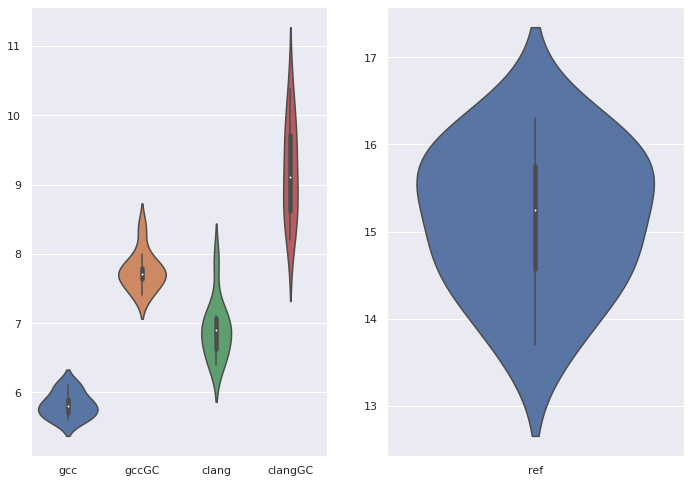

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = plt.subplots(1,2)
sns.violinplot(data=df_sudoku[['gcc', 'gccGC', 'clang', 'clangGC']], ax=ax[0])
sns.violinplot(data=df_sudoku[['ref']], ax=ax[1])

## Ants
Both compilers are not very consistent here, it is probably due to the benchmark being very short.

<AxesSubplot:>

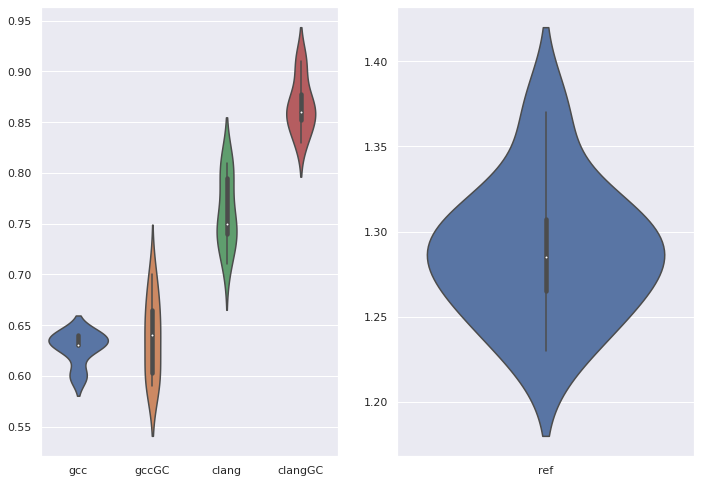

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = plt.subplots(1,2)
sns.violinplot(data=df_ants[['gcc', 'gccGC', 'clang', 'clangGC']], ax=ax[0])
sns.violinplot(data=df_ants[['ref']], ax=ax[1])

## Appendix
### Memory management
The implementation uses custom buddy allocator. If used with stdlib memory functions (malloc, free...) it runs roughly 1.1x faster on gcc. This may be because interpreter does not free almost any memory that represents runtime FML objects, so it cannot take advantage of the fragmentation that buddy allocator fixes. 